In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/데이터공유폴더/open.zip'
!unzip open/train.zip 
!unzip open/test.zip
!mv train ./open
!mv test ./open 

In [ ]:
!git clone https://github.com/crimama/MVtecAD.git 
%cd './MVtecAD'


In [ ]:
!pip install timm

In [5]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
import time
import matplotlib.pyplot as plt 


device = torch.device('cuda')

from utils.dataset import Custom_dataset
from model.base_model import Network

#이미지, 라벨 데이터 로드 해 옴 
def load_data(path):
    #이미지 path 
    train_png = np.array(sorted(glob(f'{path}/train/*.png')))
    test_png = np.array(sorted(glob(f'{path}/test/*.png')))
    
    #라벨 인코더 
    train_labels = pd.read_csv(f"{path}/train_df.csv")['label']
    label_unique = sorted(np.unique(train_labels))
    label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}
    
    #라벨 
    train_labels = [label_unique[k] for k in train_labels]
    
    return np.array(train_png),np.array(test_png),label_unique, np.array(train_labels )

#데이터 패스 받아서 데이터 로더로 바로 반환 
def make_loader(train_index,valid_index,batch_size):
    global train_png, train_labels 
    train_x = train_png[train_index]
    train_y = train_labels[train_index]
    
    valid_x = train_png[valid_index]
    valid_y = train_labels[valid_index]
    
    train_dataset = Custom_dataset(train_x,train_y)
    valid_dataset = Custom_dataset(valid_x,valid_y)

    train_loader = DataLoader(train_dataset,batch_size,shuffle=True)
    valid_loader = DataLoader(valid_dataset,batch_size,shuffle=False)
    return train_loader,valid_loader

#예측, 실제 값 F1 score 계산 
def score_function(real,pred):
    score = f1_score(real,pred,average='macro')
    return score 

#학습 도중 모델 세이브 
def model_save(model,epoch):
    torch.save(model.state_dict(),f'./saved_model/best_model_{epoch}.pt')


    
def train(train_loader,model,optmizer,):
    start = time.time()
    train_loss = 0 
    train_pred = [] 
    train_y = [] 
    model.train() 
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0],dtype=torch.float32,device=device)
        y = torch.tensor(batch[1],dtype=torch.long,device=device)
        with torch.cuda.amp.autocast(): #<-- mixed precision 
            pred = model(x)
        loss = criterion(pred,y) 
        
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    
    
    #plot_losses 
    if epoch ==0:
        loss_history.append(train_loss)
    else:
        loss_history.append(train_loss)
        plt.plot(np.arange(epoch+1),np.array(loss_history))
        
        
    #Evaluate 
    train_f1 = score_function(train_y,train_pred) 
    
    #model save 
    if train_f1 > best:
        best = train_f1 
        model_save(model,epoch)
        
    TIME = time.time() - start 
    
    print(f'epoch : {epoch+1}/{CFG.epochs}    time : {TIME:.0f}s/{TIME*(CFG.epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
    

  4%|▍         | 1/25 [02:46<1:06:29, 166.25s/it]

epoch : 1/25    time : 166s/3990s
TRAIN    loss : 0.00207    f1 : 0.14405


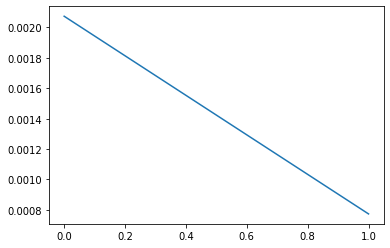

  8%|▊         | 2/25 [05:26<1:02:17, 162.49s/it]

epoch : 2/25    time : 160s/3677s
TRAIN    loss : 0.00077    f1 : 0.22349


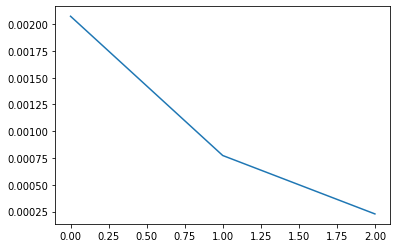

 12%|█▏        | 3/25 [08:04<58:56, 160.74s/it]  

epoch : 3/25    time : 159s/3490s
TRAIN    loss : 0.00023    f1 : 0.30499


 12%|█▏        | 3/25 [09:11<1:07:20, 183.67s/it]


KeyboardInterrupt: ignored

In [13]:
#하이퍼 파라미터들 
class CFG:
    path = '/content/open/'
    batch_size = 8 
    epochs = 25 
    shuffle = True 
#data path load     
train_png, test_png, label_unique, train_labels = load_data(CFG.path)

#KFold 
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(train_png):
    train_loader, valid_loader = make_loader(train_index,valid_index,CFG.batch_size)

    #학습 전 세팅 
    model = Network().to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()

    best = 0 
    loss_history = [] 
    #----------------------------train-----------------------------
    for epoch in tqdm(range(CFG.epochs)):
      start = time.time()
      
      train_pred = []
      train_y = [] 
      
      model.train()
      for batch in (train_loader):
        optimizer.zero_grad()
        train_loss = 0 
        x = torch.tensor(batch[0],dtype=torch.float32,device=device)
        y = torch.tensor(batch[1],dtype=torch.long,device=device)

        with torch.cuda.amp.autocast():
          pred = model(x)
        loss = criterion(pred,y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    #--------------------------Valid------------------------------------
    #--------------------------Evaluate---------------------------------
      #plot_losses 
      if epoch == 0:
        loss_history.append(train_loss)
      else:
        loss_history.append(train_loss)
        plt.plot(np.arange(epoch+1),np.array(loss_history))
        plt.show() 

      #Evaluate 
      train_f1 = score_function(train_y,train_pred) 

      #model save 
      # if train_f1 > best:
      #   best = train_f1
      #   model_save(model,epoch)

      TIME = time.time() - start 

      print(f'epoch : {epoch+1}/{CFG.epochs}    time : {TIME:.0f}s/{TIME*(CFG.epochs-epoch-1):.0f}s')
      print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')
      
    
    

In [23]:
cd

total 80
drwx------ 2 root root  4096 Jun 13 14:44 '기타 영상작업'/
drwx------ 2 root root  4096 Jun 13 14:58  보관용/
drwx------ 2 root root  4096 Aug  5 10:22  2022_kaggle_competition/
-rw------- 1 root root  2815 Jun 10 15:59 'Anaconda Prompt (anaconda3).lnk'
-rw------- 1 root root 40073 Aug  6 07:22  dacaon_paldang.ipynb
drwx------ 2 root root  4096 May 25 08:05  DL_study/
-rw------- 1 root root  9146 Sep  6 15:30  for_commit.ipynb
drwx------ 2 root root  4096 Jun 14 06:08  IOT_education/
drwx------ 2 root root  4096 Aug 30 01:59  MVtecAD/
drwx------ 2 root root  4096 Aug  4 05:22  Pytorch_vision/


# Inference 

In [ ]:
model.load_state_dict(torch.load('./model/best_model_29.pt'))
#데이터 
test_dataset = Custom_dataset(np.array(test_png),np.array(['tmp']*len(test_png)),mode='test')

test_dataloader = DataLoader(test_dataset,batch_size=CFG.batch_size,shuffle=False)

model.eval()
f_pred = [] 

with torch.no_grad():
    for batch in (test_dataloader):
        x = torch.tensor(batch[0],dtype=torch.float32,device=device)
        with torch.cuda.amp.autocast():
            pred = model(x) 
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]
submission = pd.read_csv('./data/open/sample_submission.csv')
submission['label'] = f_result
submission.to_csv('submission0906_1.csv',index=False)


<All keys matched successfully>